# 美学感知
审美是一种主观感受，不同的人对美的感知也各有不同。
SCUT-FBP[1]数据集中，采集了5500张人脸数据，包括了中西方男性与女性，并请了60位志愿者对图片进行打分。
展示其中的部分数据：

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle('beauty_data.pkl')

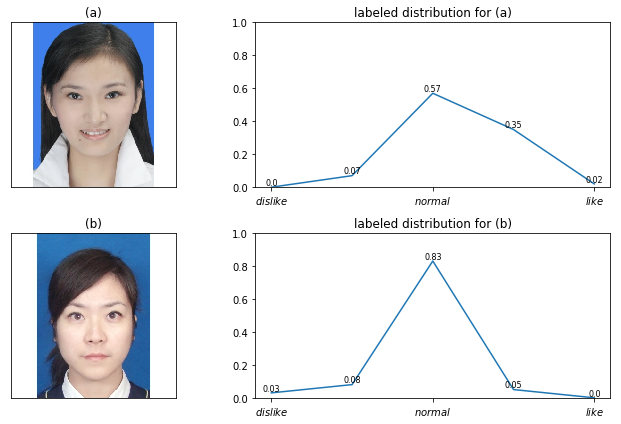

In [43]:
example1 = data.iloc[55]
img1 = example1['img']
label1 = example1['labels']
example2 = data.iloc[75]
img2 = example2['img']
label2 = example2['labels']

label = np.linspace(1,5,5)

plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.title('(a)')

plt.subplot(2,2,2)
plt.plot(label, label1)
plt.ylim(0,1)
for a, b in zip(label, label1):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.xticks([1, 3, 5],[r'$dislike$',  r'$normal$', r'$like$'])
plt.title('labeled distribution for (a)')

plt.subplot(2,2,3)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.title('(b)')

plt.subplot(2,2,4)
plt.plot(label, label2)
plt.ylim(0,1)
for a, b in zip(label, label2):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.xticks([1,  3,  5],[r'$dislike$',  r'$normal$',  r'$like$'])
plt.title('labeled distribution for (b)')

#plt.subplots_adjust(wspace =0.2, hspace =0.7)#调整子图间距
plt.tight_layout()
    
plt.show()

如上图所示，折线图为志愿者的评价分布。若采用传统的方法，可能对两者的标记结果均为‘normal’，或是采用打分的均值作为标记。然而，从分布可知，志愿者对两者的评价是非常不同的，对(a)，其实有一部分志愿者是偏喜欢的，而对(b)则是很集中的表示一般喜欢。因此，我们选择采用标记分布[2]来描述不同人的不同看法。

In [4]:
img1.shape

(350, 350, 3)

# Build Model
模型采用了ResNet50提取特征，并用ImageNet数据进行预训练。最后增加一个全局池化层，一层全连接层进行训练，最后通过softmax层输出分布结果。

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [115]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dropout
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

input_tensor = Input(shape=(350, 350, 3))

base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
#x = Dropout(0.2)(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)

for layer in model.layers[:47]:
   layer.trainable = False
for layer in model.layers[47:]:
   layer.trainable = True

/data/ry/anaconda3_new/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
train_set_prop = 0.6
val_set_prop = 0.2
test_set_prop = 0.2

num = len(data)
train_size = round(num*train_set_prop)
train_data = data.iloc[0:train_size]
val_size = round(num*val_set_prop)
val_data = data.iloc[train_size:(train_size+val_size)]
test_size = round(num*test_set_prop)
test_data = data.iloc[(train_size+val_size):(train_size+val_size+test_size)]

train_input = train_data['img']
train_input = [x for x in train_input]
train_input = np.array(train_input)
train_labels = train_data['labels']
train_labels = [x for x in train_labels]
train_labels = np.array(train_labels)
val_input = val_data['img']
val_input = [x for x in val_input]
val_input = np.array(val_input)
val_labels = val_data['labels']
val_labels = [x for x in val_labels]
val_labels = np.array(val_labels)
test_input = test_data['img']
test_input = [x for x in test_input]
test_input = np.array(test_input)
test_labels = test_data['labels']
test_labels = [x for x in test_labels]
test_labels = np.array(test_labels)

In [116]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='sgd', loss='mean_squared_error')
history = model.fit(train_input, train_labels, batch_size=16, epochs=5, verbose=1,validation_data=(val_input, val_labels))
pred = model.predict(test_input, batch_size=16)

Train on 600 samples, validate on 200 samples
Epoch 1/5
600/600 [==============================] - 113s 189ms/step - loss: 0.0303 - val_loss: 0.0513
Epoch 2/5
600/600 [==============================] - 33s 55ms/step - loss: 0.0230 - val_loss: 0.0510
Epoch 3/5
600/600 [==============================] - 33s 54ms/step - loss: 0.0206 - val_loss: 0.0505
Epoch 4/5
600/600 [==============================] - 32s 54ms/step - loss: 0.0185 - val_loss: 0.0514
Epoch 5/5
600/600 [==============================] - 32s 54ms/step - loss: 0.0179 - val_loss: 0.0528


In [117]:
from sklearn.metrics import mean_squared_error

mean_squared_error(pred, test_labels)

0.059945839034783586

展示一些预测结果

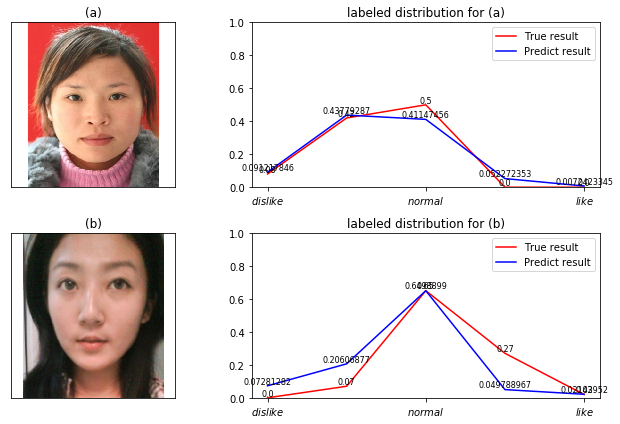

In [120]:
exp =  100
exp2 = 55

img1 = test_input[exp]
label1 = test_labels[exp,:]
label1_p = pred[exp,:]
img2 = test_input[exp2]
label2 = test_labels[exp2,:]
label2_p = pred[exp2,:]

label = np.linspace(1,5,5)

plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.title('(a)')

plt.subplot(2,2,2)
plt.plot(label, label1, color='red', label='True result')
plt.plot(label, label1_p, color='blue', label='Predict result')
plt.ylim(0,1)
for a, b, in zip(label, label1):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
for a, b, in zip(label, label1_p):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.xticks([1, 3, 5],[r'$dislike$',  r'$normal$', r'$like$'])
plt.title('labeled distribution for (a)')
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.title('(b)')

plt.subplot(2,2,4)
plt.plot(label, label2, color='red', label='True result')
plt.plot(label, label2_p, color='blue', label='Predict result')
plt.ylim(0,1)
for a, b in zip(label, label2):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
for a, b in zip(label, label2_p):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=8)
plt.xticks([1,  3,  5],[r'$dislike$',  r'$normal$',  r'$like$'])
plt.title('labeled distribution for (b)')
plt.legend(loc='upper right')
#plt.subplots_adjust(wspace =0.2, hspace =0.7)#调整子图间距
plt.tight_layout()

    
plt.show()

# 引用
[1] Liang L, Lin L, Jin L, et al. Scut-fbp5500: A diverse benchmark dataset for multi-paradigm facial beauty prediction[C]//2018 24th International Conference on Pattern Recognition (ICPR). IEEE, 2018: 1598-1603.

[2] Ren Y, Geng X. Sense Beauty by Label Distribution Learning[C]//IJCAI. 2017: 2648-2654.